# HHL for Solving $A\vec{x}=\vec{b}$

This tutorial demonstrates an implementation of the HHL algorithm for a specific matrix. The Hamiltonian evolution is implemented by an "exact" operation, explicitly evaluating $e^{iA}$.

In [1]:
import numpy as np
import scipy

a_matrix = np.array(
    [
        [0.135, -0.092, -0.011, -0.045, -0.026, -0.033, 0.03, 0.034],
        [-0.092, 0.115, 0.02, 0.017, 0.044, -0.009, -0.015, -0.072],
        [-0.011, 0.02, 0.073, -0.0, -0.068, -0.042, 0.043, -0.011],
        [-0.045, 0.017, -0.0, 0.043, 0.028, 0.027, -0.047, -0.005],
        [-0.026, 0.044, -0.068, 0.028, 0.21, 0.079, -0.177, -0.05],
        [-0.033, -0.009, -0.042, 0.027, 0.079, 0.121, -0.123, 0.021],
        [0.03, -0.015, 0.043, -0.047, -0.177, -0.123, 0.224, 0.011],
        [0.034, -0.072, -0.011, -0.005, -0.05, 0.021, 0.011, 0.076],
    ]
)

b_vector = np.array(
    [
        -0.00885448,
        -0.17725898,
        -0.15441119,
        0.17760157,
        0.41428775,
        0.44735303,
        -0.71137715,
        0.1878808,
    ]
)

sol_classical = np.linalg.solve(a_matrix, b_vector)  # classical solution

# number of qubits for the unitary
num_qubits = int(np.log2(len(b_vector)))
# exact unitary
my_unitary = scipy.linalg.expm(1j * 2 * np.pi * a_matrix)

In [2]:
# transpilation_options = {"classiq": "custom", "qiskit": 3} #uncomment this for deeper comparison
transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

## 1. HHL with Classiq

An HHL solver is tested for different precisions of the QPE size. The following function gets precision and returns the characteristics of the quantum program, as well as the overlap between the classical and the quantum solver.

In [3]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import floor, log
from classiq.synthesis import set_execution_preferences


@qfunc
def simple_eig_inv(phase: QNum, indicator: Output[QBit]):
    allocate(1, indicator)
    indicator *= (1 / 2**phase.size) / phase


@qfunc
def my_hhl(
    precision: CInt,
    b: CArray[CReal],
    unitary: QCallable[QArray[QBit]],
    res: Output[QArray[QBit]],
    phase: Output[QNum],
    indicator: Output[QBit],
) -> None:
    prepare_amplitudes(b, 0.0, res)
    allocate_num(precision, False, precision, phase)
    within_apply(
        lambda: qpe(unitary=lambda: unitary(res), phase=phase),
        lambda: simple_eig_inv(phase=phase, indicator=indicator),
    )


def get_classiq_hhl_results(precision):
    """
    This function models, synthesizes, executes an HHL example and returns the depth, cx-counts and fidelity
    """

    # SP params
    b_normalized = b_vector.tolist()
    sp_upper = 0.00  # precision of the State Preparation
    unitary_mat = my_unitary.tolist()

    @qfunc
    def main(res: Output[QNum], phase: Output[QNum], indicator: Output[QBit]):
        my_hhl(
            precision=precision,
            b=b_normalized,
            unitary=lambda target: unitary(elements=unitary_mat, target=target),
            res=res,
            phase=phase,
            indicator=indicator,
        )

    qmod_hhl = create_model(main)
    backend_preferences = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )
    qmod_hhl = set_preferences(
        qmod_hhl,
        custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
        transpilation_option=transpilation_options["classiq"],
    )
    qmod_hhl = set_execution_preferences(
        qmod_hhl,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )

    # Synthesize
    qprog_hhl = synthesize(qmod_hhl)
    total_q = qprog_hhl.data.width  # total number of qubits of the whole circuit
    depth = qprog_hhl.transpiled_circuit.depth
    cx_counts = qprog_hhl.transpiled_circuit.count_ops["cx"]

    # Execute
    result = execute(qprog_hhl).result_value()

    # Post-process
    target_pos = result.physical_qubits_map["indicator"][0]  # position of control qubit
    sol_pos = list(result.physical_qubits_map["res"])  # position of solution
    phase_pos = list(
        result.physical_qubits_map["phase"]
    )  # position of the “phase” register, and flips for endianness as we will use the indices to read directly from the string
    qsol = [
        np.round(parsed_state.amplitude / (1 / 2**precision), 5)
        for solution in range(2**num_qubits)
        for parsed_state in result.parsed_state_vector
        if parsed_state["indicator"] == 1.0
        and parsed_state["res"] == solution
        and parsed_state["phase"]
        == 0.0  # this takes the entries where the “phase” register is at state zero
    ]
    fidelity = (
        np.abs(
            np.dot(
                sol_classical / np.linalg.norm(sol_classical),
                qsol / np.linalg.norm(qsol),
            )
        )
        ** 2
    )
    return total_q, depth, cx_counts, fidelity

In [4]:
classiq_widths = []
classiq_depths = []
classiq_cx_counts = []
classiq_fidelities = []
for per in range(2, 9):
    total_q, depth, cx_counts, fidelity = get_classiq_hhl_results(per)
    classiq_widths.append(total_q)
    classiq_depths.append(depth)
    classiq_cx_counts.append(cx_counts)
    classiq_fidelities.append(fidelity)

In [5]:
print("classiq overlap:", classiq_fidelities)
print("classiq depth:", classiq_depths)

classiq overlap: [0.31375892884364376, 0.4338770556442726, 0.5603088004464546, 0.6943620279028347, 0.8120390423999257, 0.9428406320922575, 0.9982199414655266]
classiq depth: [1139, 1672, 2213, 2770, 3359, 4012, 4793]


## 2. Comparing to Qiskit

Qiskit's HHL solver has been deprecated. For comparison, in an analogy to the Classiq model above, wire the four quantum blocks of the HHL algorithm in Qiskit.

The qiskit data was generated using qiskit version 1.0.0. To run the qiskit code uncomment the commented cells below.

In [6]:
qiskit_fidelities = [
    0.3158037121175521,
    0.43599529278857063,
    0.5586003448231571,
    0.6824252904259536,
    0.806169290650212,
    0.9243747525650154,
    1.0,
]
qiskit_depths = [1921, 4439, 9451, 19455, 39443, 79399, 159291]
qiskit_widths = [6, 7, 8, 9, 10, 11, 12]
qiskit_cx_counts = [979, 2263, 4819, 9915, 20087, 40407, 81019]

In [7]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

In [8]:
# from qiskit import QuantumCircuit, QuantumRegister, transpile
# from qiskit.quantum_info import Statevector
# from qiskit.circuit.library import PhaseEstimation as PhaseEstimation_QISKIT
# from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
# from qiskit.circuit.library import Isometry, Initialize

# def get_qiskit_hhl_results(precision):
#     """
#     This function creates an HHL circuit with qiskit, execute it and returns the depth, cx-counts and fidelity
#     """

#     vector_circuit = QuantumCircuit(num_qubits)
#     initi_vec = Initialize(b_vector / np.linalg.norm(b_vector))

#     vector_circuit.append(
#         initi_vec, list(range(num_qubits))
#     )

#     q = QuantumRegister(num_qubits, "q")
#     unitary_qc = QuantumCircuit(q)
#     unitary_qc.unitary(my_unitary.tolist(), q)
#     qpe_qc = PhaseEstimation_QISKIT(precision, unitary_qc)
#     reciprocal_circuit = ExactReciprocal(
#         num_state_qubits=precision, scaling=1 / 2**precision
#     )
#     # Initialise the quantum registers
#     qb = QuantumRegister(num_qubits)  # right hand side and solution
#     ql = QuantumRegister(precision)  # eigenvalue evaluation qubits
#     qf = QuantumRegister(1)  # flag qubits

#     hhl_qc = QuantumCircuit(qb, ql, qf)

#     # State preparation
#     hhl_qc.append(vector_circuit, qb[:])
#     # QPE
#     hhl_qc.append(qpe_qc, ql[:] + qb[:])
#     # Conditioned rotation
#     hhl_qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])

#     # QPE inverse
#     hhl_qc.append(qpe_qc.inverse(), ql[:] + qb[:])

#     # transpile
#     tqc = transpile(
#         hhl_qc,
#         basis_gates=["u3", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     depth = tqc.depth()
#     cx_counts = tqc.count_ops()["cx"]
#     total_q = tqc.width()

#     # execute
#     statevector = np.array(Statevector(tqc))

#     # post_process
#     all_entries = [np.binary_repr(k, total_q) for k in range(2**total_q)]
#     sol_indices = [
#         int(entry, 2)
#         for entry in all_entries
#         if entry[0] == "1" and entry[1 : precision + 1] == "0" * precision
#     ]
#     qsol = statevector[sol_indices] / (1 / 2**precision)

#     sol_classical = np.linalg.solve(a_matrix, b_vector)
#     fidelity = (
#         np.abs(
#             np.dot(
#                 sol_classical / np.linalg.norm(sol_classical),
#                 qsol / np.linalg.norm(qsol),
#             )
#         )
#         ** 2
#     )

#     return total_q, depth, cx_counts, fidelity

In [9]:
# qiskit_widths = []
# qiskit_depths = []
# qiskit_cx_counts = []
# qiskit_fidelities = []

# for per in range(2, 9):
#     total_q, depth, cx_counts, fidelity = get_qiskit_hhl_results(per)
#     qiskit_widths.append(total_q)
#     qiskit_depths.append(depth)
#     qiskit_cx_counts.append(cx_counts)
#     qiskit_fidelities.append(fidelity)

## 3. Plotting the Data

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9000000000000001, 0, '0.9'),
  Text(1.0, 0, '1.0'),
  Text(1.1, 0, '1.1')])

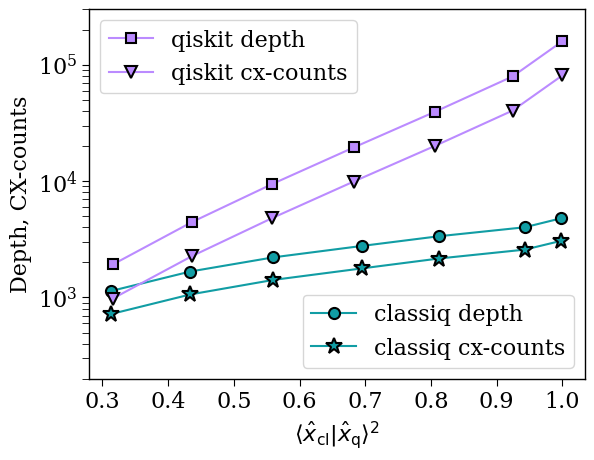

In [10]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5


(classiq1,) = plt.semilogy(
    classiq_fidelities,
    classiq_depths,
    "-o",
    label="classiq depth",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(classiq2,) = plt.semilogy(
    classiq_fidelities,
    classiq_cx_counts,
    "-*",
    label="classiq cx-counts",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=12,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(qiskit1,) = plt.semilogy(
    qiskit_fidelities,
    qiskit_depths,
    "-s",
    label="qiskit depth",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)
(qiskit2,) = plt.semilogy(
    qiskit_fidelities,
    qiskit_cx_counts,
    "-v",
    label="qiskit cx-counts",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)

first_legend = plt.legend(
    handles=[qiskit1, qiskit2],
    fontsize=16,
    loc="upper left",
)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[classiq1, classiq2], fontsize=16, loc="lower right")

# plt.ylim(0.2e3,2e5)
plt.ylim(0.2e3, 3e5)
plt.ylabel("Depth, CX-counts", fontsize=16)
plt.xlabel(r"$\langle\hat{x}_{\rm cl}|\hat{x}_{\rm q}\rangle^2$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)